In [48]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib
import seaborn as sns

# Part 1 

In [49]:
def generatePoints(num, pies, mus, sigmas):    
    np.random.seed(0)
    if len(mus) > 0:
        dim = len(mus[0])
        X = np.empty((0, dim))
        for idx, pie in enumerate(pies):
            X = np.concatenate((X, np.random.multivariate_normal(mus[idx], sigmas[idx], int(pie*num))), axis=0)
        return np.array(X)
    

In [50]:
X = generatePoints(500, [0.2, 0.5, 0.3], [[0, 0], [3, 0], [0, 3]], [[[1,0],[0,1]], [[1,0],[0,1]], [[1,0],[0,1]]])

In [51]:
class KMeans:
    def __init__(self, K):
        np.random.seed(0)
        self.K = K
    
    def train(self, X, iterations=1000000):
        if X.shape[0] > 0:            
            self.centroids = X[np.random.choice(X.shape[0], self.K, replace=False), :]
            self.c = np.empty((X.shape[0]), dtype=int)
            self.losses = []
                        
            for _ in range(iterations):
                
                # assign points to cluster
                for idx, x in enumerate(X):
                    self.c[idx] = np.argmin(self.dist(x, self.centroids, dtype='euclidean'), axis=0)
                
                # caliculate centroids
                for k in range(self.K):
                    indices = (self.c==k)
                    if X[indices].shape[0] > 0:
                        self.centroids[k] = np.mean(X[indices, :], axis=0)
                                
                self.losses.append(self.loss(X))             
    
    def dist(self, X1, X2, dtype='euclidean'):
        if dtype == 'euclidean':
            return np.linalg.norm(X1 - X2, axis=1) ** 2
        else:
            pass
        
    def plotClusters(self, X, save_name='1-clusters.png'):
        colors = np.array(['pink', 'green', 'blue', 'yellow', 'purple', 'white'])
        sns.set()
        sns.set(font_scale=3)
        plt.figure(figsize=(15,10))
        for k in range(self.K):
            indices = self.c == k
            plt.scatter(X[indices, 0], X[indices, 1], color=colors[k], label='Cluster-{}'.format(k+1))
        plt.scatter(self.centroids[:, 0], self.centroids[:, 1], color=['red']*self.centroids.shape[0], \
                    marker="D", label='Centroid')
        plt.xlabel('x0')
        plt.ylabel('x1')
        plt.legend(fontsize=20)
        plt.title('K={}'.format(self.K))
        plt.savefig(save_name)
        plt.show()
    
    def plotLoss(self, save_name='1-loss.png'):
        sns.set(font_scale=3)
        matplotlib.rc('font', size=30)
        plt.figure(figsize=(15,10))
        plt.plot(self.losses)
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.title('Loss vs Iterations for K={}'.format(self.K))        
        plt.savefig(save_name)
        plt.show()
        
    def loss(self, X):
        total_loss = 0
        for k in range(self.K):
            c_loss = np.sum(np.linalg.norm(X[self.c == k] - self.centroids[k], axis=1) ** 2)
#             print(c_loss)
            total_loss += c_loss
        
        return total_loss

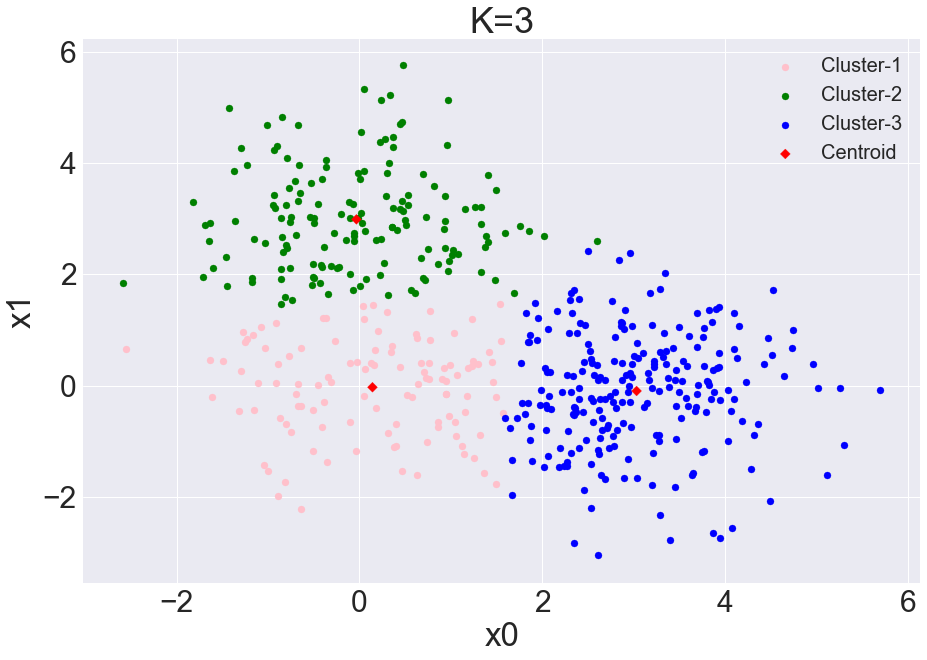

In [52]:
model = KMeans(K=3)
model.train(X, iterations=50)
model.plotClusters(X)

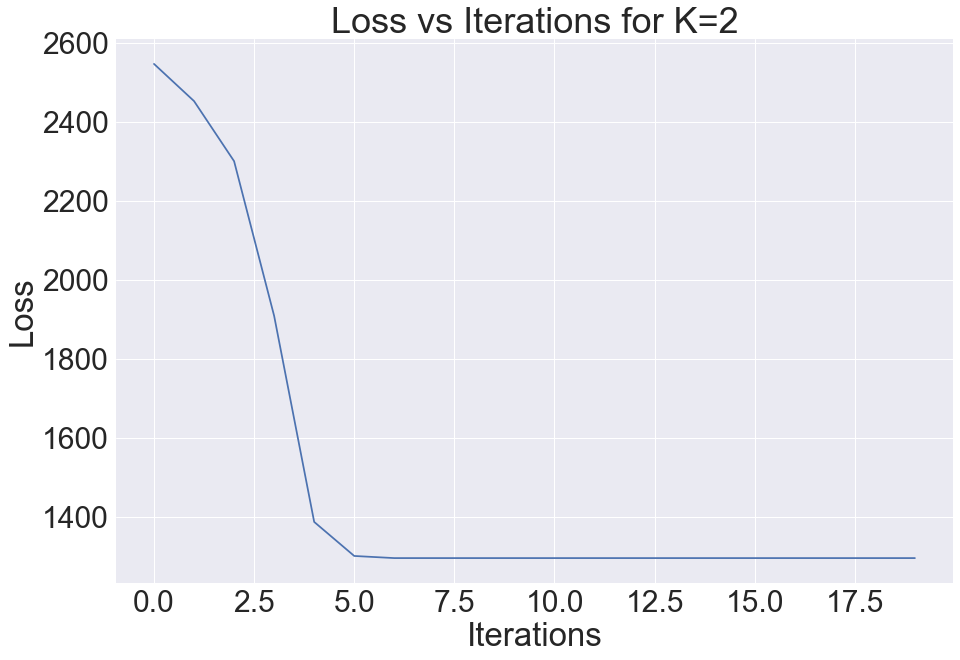

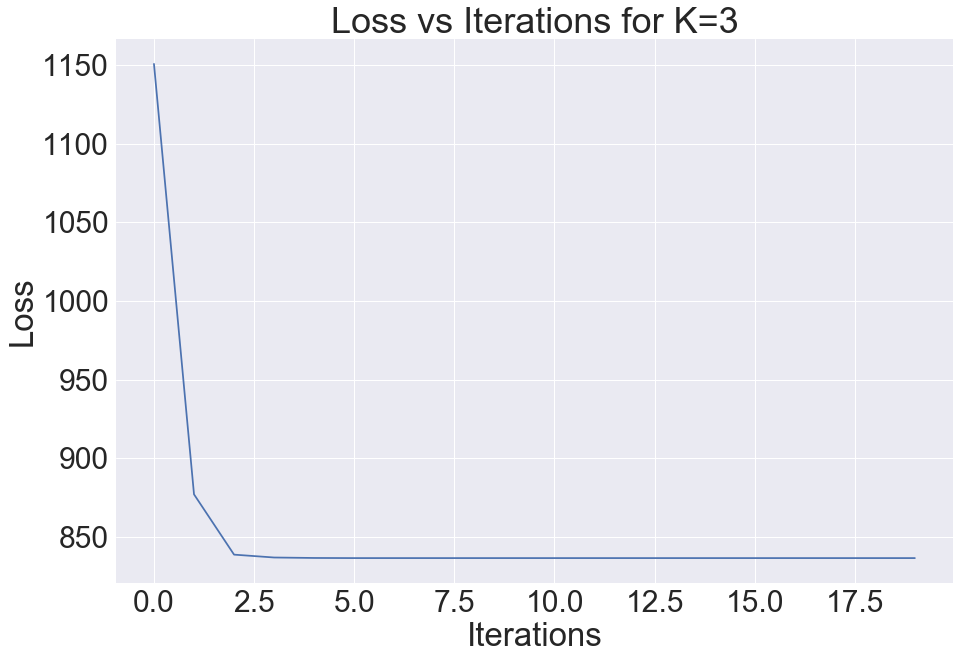

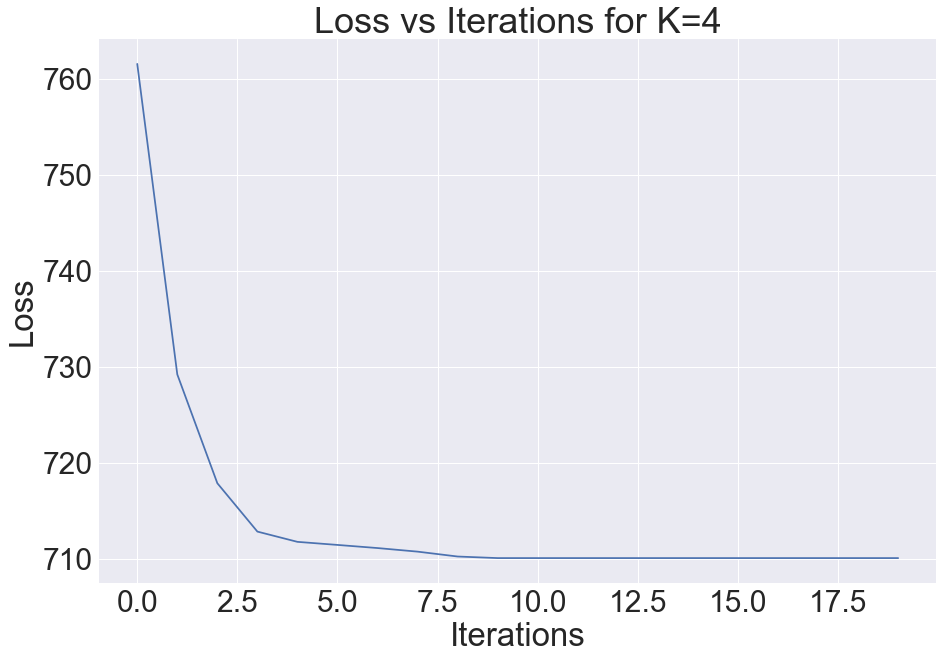

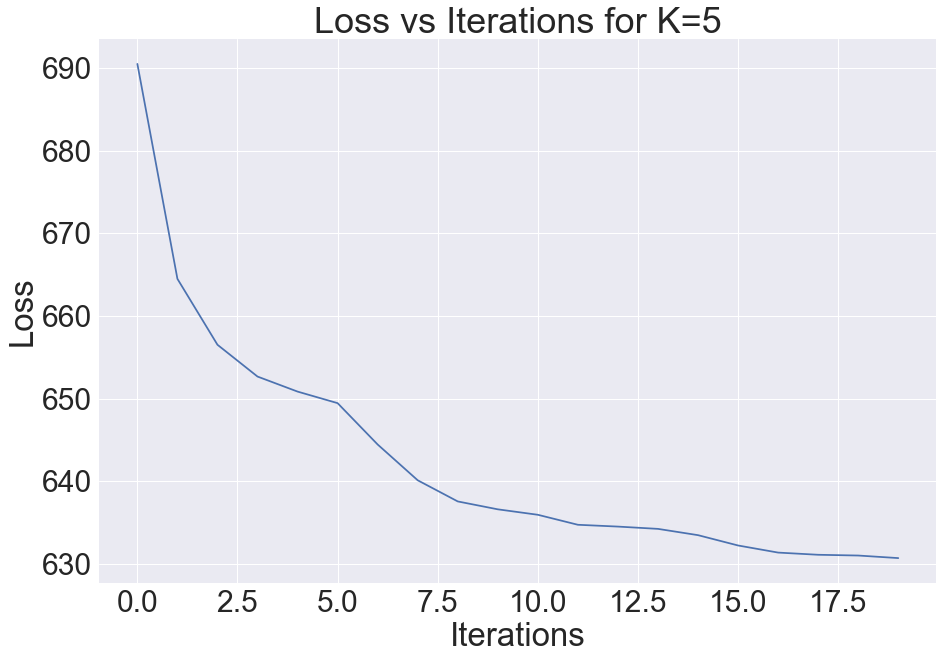

In [53]:
# plot loss for each K-Means model
for k in [2,3,4,5]:
    model = KMeans(K=k)
    model.train(X, iterations=20)
    model.plotLoss(save_name='1-a-loss-{}.png'.format(k))

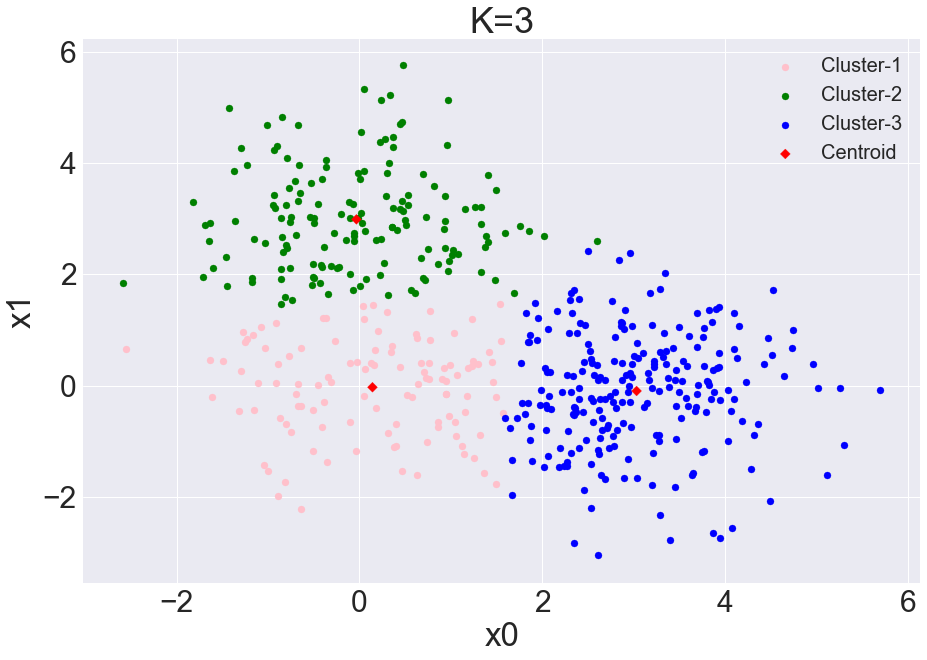

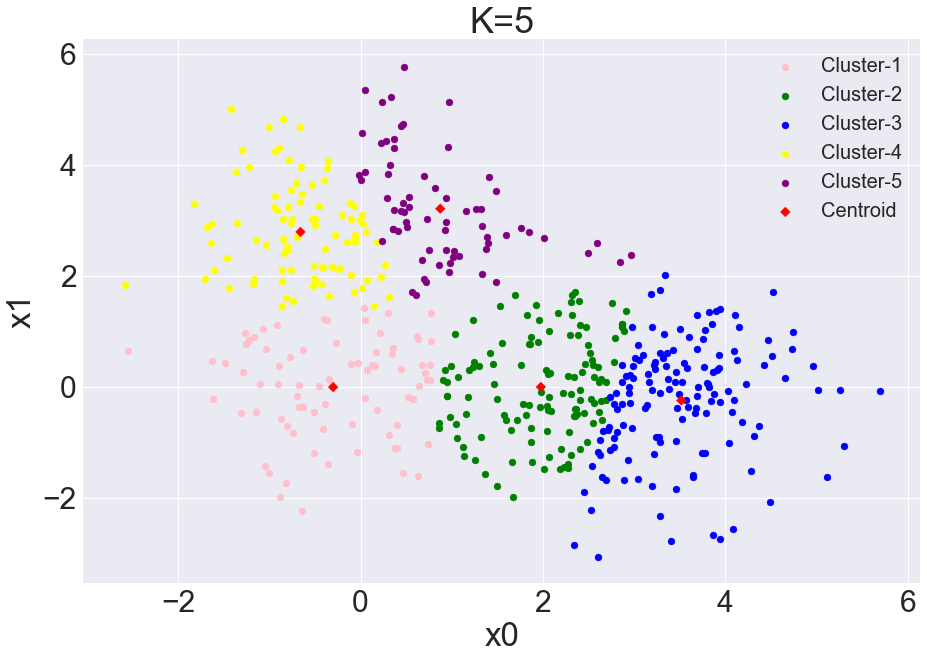

In [54]:
#plot clusters for each K-Means model
for k in [3, 5]:
    model = KMeans(K=k)
    model.train(X, iterations=20)
    model.plotClusters(X, save_name='1-b-clusters-{}.png'.format(k))

# Part 2 

In [33]:
# Helper Code to convert a data frame to image
# Referenced from https://stackoverflow.com/a/39358722/2066052

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import six

df = pd.DataFrame()
df['date'] = ['2016-04-01', '2016-04-02', '2016-04-03']
df['calories'] = [2200, 2100, 1500]
df['sleep hours'] = [2200, 2100, 1500]
df['gym'] = [True, False, False]


def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

#render_mpl_table(df, header_columns=0, col_width=2.0).get_figure().savefig('demo.png')

## Matrix Factorization

In [34]:
from numpy import genfromtxt
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd 

In [35]:
def load_train_data():
    return genfromtxt('hw4-data/ratings.csv', delimiter=',')
def load_test_data():
    return genfromtxt('hw4-data/ratings_test.csv', delimiter=',')

def load_movies():
    with open('hw4-data/movies.txt') as f:
        content = f.readlines()
        content = [x.strip() for x in content]
        return content

ratings_raw_train = load_train_data()
ratings_raw_test = load_test_data()
movies_data = load_movies()

In [36]:
class MatrixFactorization:
    def __init__(self, lambd, cov, d):
        self.lambd = lambd
        self.cov = cov
        self.d = d
        
    def createM(self, ratings_raw):
        
        N1 = int(np.max(np.unique(ratings_raw[:,0]))+1)
        N2 = int(np.max(np.unique(ratings_raw[:,1]))+1)
        
#         M = np.full(shape=(N1, N2), fill_value=None)
        M = np.zeros(shape=(N1, N2))
        
        for row in ratings_raw:
            M[int(row[0]) - 1][int(row[1]) - 1] = row[2]
            
        return M, N1, N2
    
    def train(self, M, N1, N2, iterations, is_calc_log_likelihood=True):

        self.u = np.empty(shape=(N1, self.d))
        self.v = np.empty(shape=(self.d, N2))
        
        self.log_likelihoods = []
        
        for j in range(N2):
            self.v[:, j] = np.random.multivariate_normal(mean=np.zeros((self.d)), cov=1/self.lambd * np.identity(self.d))
        
        
        for iter in range(1, iterations+1):
        
            for i in range(N1):
                hasRating = M[i, :] != 0
                tempV = self.v[:, hasRating]
                leftPart = np.linalg.inv(self.lambd*self.cov*np.identity(self.d) + np.dot(tempV, tempV.T))
                rightPart = np.dot(tempV, M[i, hasRating])
                self.u[i, :] = np.dot(leftPart, rightPart)
                
            # for each j: 1..N2
            for j in range(N2):
                isGivenRating = M[:, j] != 0
                tempU = self.u[isGivenRating, :]
                l = np.sum(isGivenRating)
                leftPart = np.linalg.inv(self.lambd*self.cov*np.identity(self.d) + np.dot(tempU.T, tempU))
                rightPart = np.dot(tempU.T, M[isGivenRating, j])
                self.v[:, j] = np.dot(leftPart, rightPart)      
            
            if is_calc_log_likelihood and iter >= 2:
                self.log_likelihoods.append(self.calc_log_likelihood(M, N1, N2))
    
        self.log_likelihoods = np.array(self.log_likelihoods)
    
    def predict(self, ratings_raw):
        preds = []
        for row_num in range(len(ratings_raw)):
            preds.append(np.dot(self.u[int(ratings_raw[row_num, 0]-1), :], self.v[:, int(ratings_raw[row_num, 1]-1)]))
        
        return np.array(preds)

    def predict_single(self, ratings_raw, row_num):
        np.dot(self.u[int(ratings_raw[row_num, 0]-1), :], self.v[:, int(ratings_raw[row_num, 1]-1)])
    
    def calc_log_likelihood(self, M, N1, N2):
        
        preds = np.dot(self.u, self.v)
        
        firstPart = (1/2*self.cov)* np.linalg.norm((M != 0) * ((M - preds) ** 2))
        secondPart = (self.lambd / 2) * np.linalg.norm(self.u) ** 2
        thirdPart = (self.lambd / 2) * np.linalg.norm(self.v) ** 2
        
        return -(firstPart + secondPart + thirdPart)                    
        
    def calc_rmse(self, ratings_raw):
        preds = self.predict(ratings_raw)
        return (np.linalg.norm(preds-ratings_raw[:, 2])**2 / len(ratings_raw[:, 2])) ** 0.5
    
    def get_similar_objects(self, movies, movie_name, count=10):
        object_id = None
        for i, movie in enumerate(movies):
            if movie_name in movie:
                object_id = i
                break
        assert(object_id)
        dists = np.linalg.norm(self.v - self.v[:, object_id].reshape(self.d, 1), axis=0)
        ids = np.argsort(dists)[1:count+1]
        res_movies = [movies[idv] for idv in ids]
        return ids, res_movies, dists[ids]

In [37]:
model = MatrixFactorization(cov=0.25, d=10, lambd=1)
M, N1, N2 = model.createM(ratings_raw_train)

In [426]:
model.train(M, N1, N2, 100)

In [250]:
ratings_raw_test = load_test_data()
preds = model.predict(load_test_data())

### part 2-a

In [63]:
def plot_log_likelihood(models):
    sns.set(font_scale=3)
    plt.figure(figsize=(15,10))
    
    for i, model in enumerate(models):
        plt.plot(model.log_likelihoods, label='run:{}'.format(i+1))
        
    plt.xlabel('Iterations')
    plt.ylabel('Log Likelihood')
    plt.title('Log Likelihood vs Iterations')
    plt.legend(fontsize=20)
    plt.savefig('2-a-1-likelihood.png')
    plt.show()

    
def getLL_RMSE(models, ratings_raw):
    lls = []
    rmses = []
    for model in models:
        lls.append(model.log_likelihoods[-1])
        rmses.append(model.calc_rmse(ratings_raw))
    
    return lls, rmses
        
def partA_train():
    models = []
    for i in range(1, 11):
        print('run: {}'.format(i))
        model = MatrixFactorization(cov=0.25, d=10, lambd=1)
        M, N1, N2 = model.createM(ratings_raw_train)
        model.train(M, N1, N2, 100, is_calc_log_likelihood=True)
        models.append(model)
    return models

def suggest_movies(model, movies_data, queries, count):
    for i, query_movie in enumerate(queries):
        print('\n suggestions for \"{}\":\n'.format(query_movie))
        ids, res_movies, dists = model.get_similar_objects(movies_data, query_movie, count)
        movie_suggestions = pd.DataFrame({"Suggested Movies": res_movies, "Euclidean Distance": dists})
        render_mpl_table(movie_suggestions, header_columns=0, col_width=5.2)\
        .get_figure().savefig('2-b-{}-moviesuggestions.png'.format(i+1))
        print(movie_suggestions)
        print('----------')
        movie_suggestions.to_html('movie_suggestion_{}.html'.format(i))

In [39]:
models = partA_train()

run: 1
run: 2
run: 3
run: 4
run: 5
run: 6
run: 7
run: 8
run: 9
run: 10


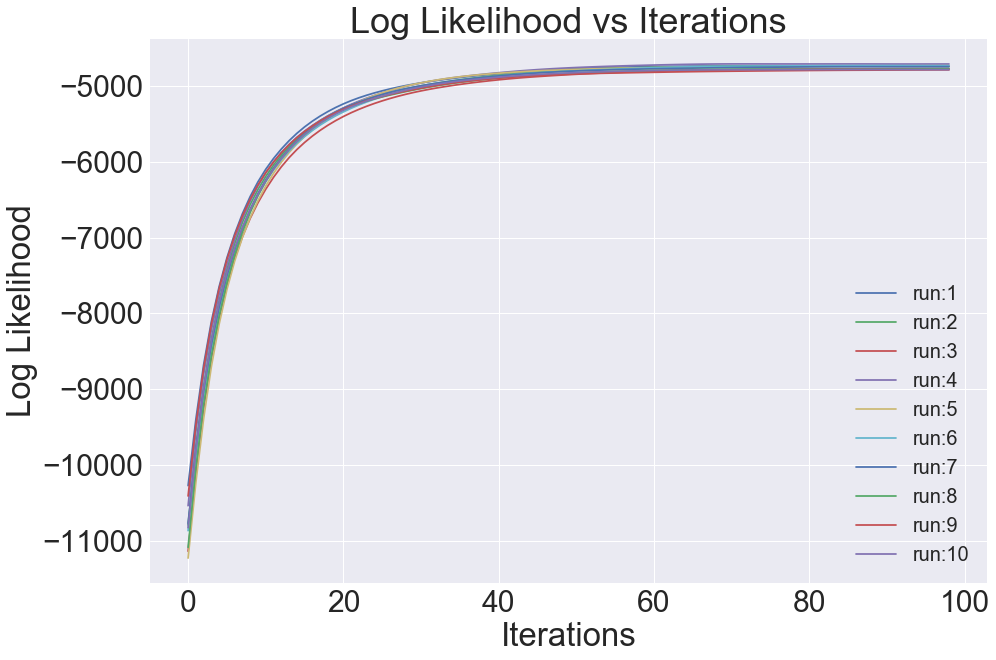

In [41]:
plot_log_likelihood(models)

### Sorted Training Objective vs RMSE

In [44]:
lls, rmses = getLL_RMSE(models, ratings_raw_test)
df = pd.DataFrame(data={'Training Objective':(lls), 'RMSE':np.array(rmses)})
df = df.sort_values(['Training Objective'], ascending=False)[['Training Objective', 'RMSE']]
df

,Training Objective,RMSE
3,-4708.530378,1.117740
4,-4731.741859,1.136180
5,-4732.112357,1.127852
0,-4733.405102,1.117149
1,-4742.344117,1.134635
6,-4743.974180,1.140704
2,-4770.644083,1.144612
7,-4774.115425,1.153234
9,-4783.144831,1.083436
8,-4785.567367,1.136874


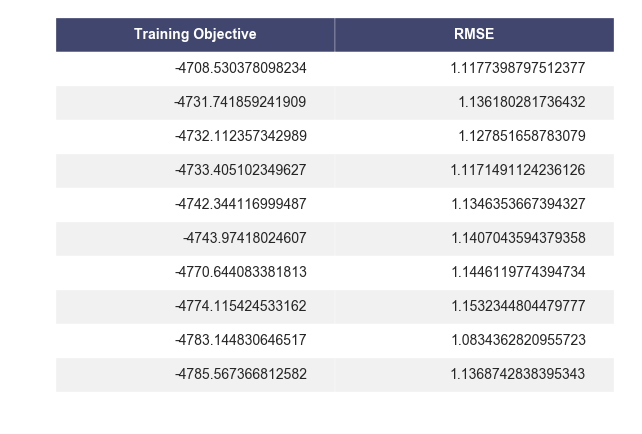

In [46]:
render_mpl_table(df, header_columns=0, col_width=5.0).get_figure().savefig('2-a-2-table.png')

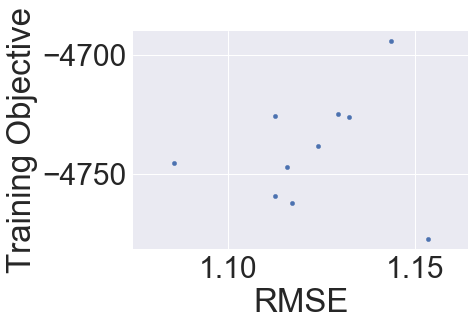

In [356]:
df.plot(kind='scatter',x =0, y=1)

### part 2-b

Star Wars -> 50
My Fair Lady -> 485
Goodfellas -> 182


 suggestions for "Star Wars":

   Euclidean Distance                           Suggested Movies
0            0.293365            Empire Strikes Back, The (1980)
1            0.536761             Raiders of the Lost Ark (1981)
2            0.626728                  Return of the Jedi (1983)
3            0.780484                 Usual Suspects, The (1995)
4            0.834720          Terminator 2: Judgment Day (1991)
5            0.865155  Indiana Jones and the Last Crusade (1989)
6            0.902155                 Princess Bride, The (1987)
7            0.915242          Man Who Would Be King, The (1975)
8            0.933933                     Terminator, The (1984)
9            0.943275                          Sting, The (1973)
----------

 suggestions for "My Fair Lady":

   Euclidean Distance                             Suggested Movies
0            0.585425                               Sabrina (1954)
1            0.784540                                  Emma (1996)
2     

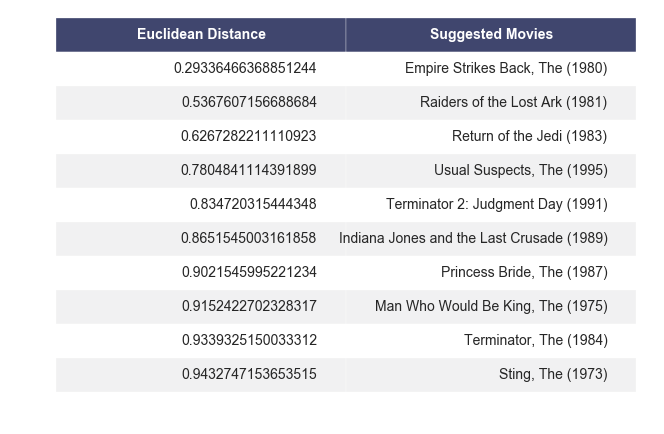

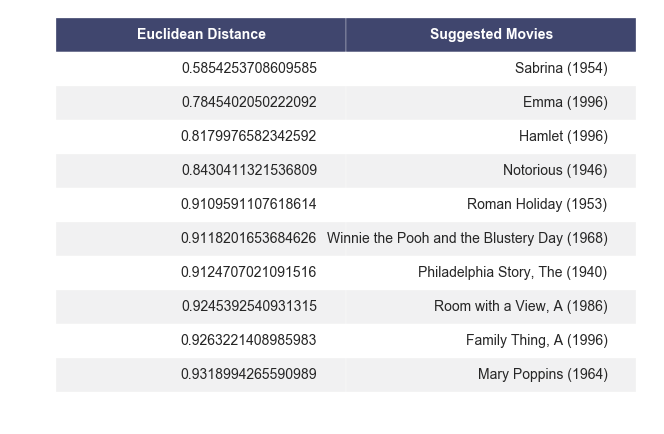

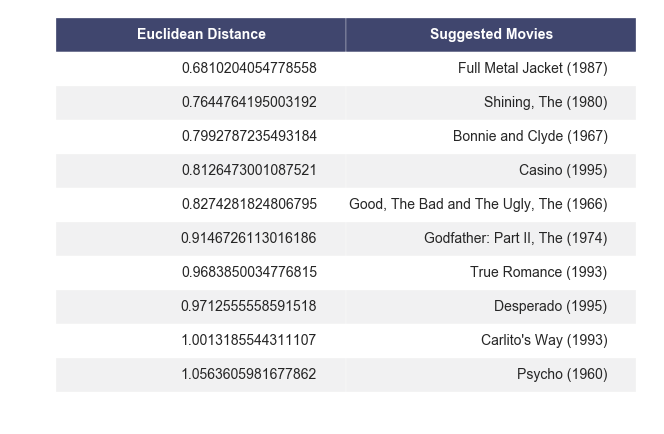

In [64]:
suggest_movies(models[df.loc[:, 'Training Objective'].idxmax(axis=0)], movies_data, ['Star Wars', 'My Fair Lady', 'GoodFellas'], count=10)